r_index: 100%|##########| 17/17 [00:00<00:00, 577.97it/s]


SMOGN generated 920 synthetic samples.
Synthetic pH distribution (unsafe <6.5 or >9.0): 70
Training set class distribution for DO_Class (encoded): {np.int64(0): np.int64(589), np.int64(1): np.int64(147)}
Training set size after SMOTE/ADASYN for DO_Class: 1178

5-Fold CV Accuracy for DO_Class: 0.79 (+/- 0.45)
Classification Metrics for DO_Class:
              precision    recall  f1-score   support

        safe       0.96      0.88      0.92       147
      unsafe       0.65      0.86      0.74        37

    accuracy                           0.88       184
   macro avg       0.81      0.87      0.83       184
weighted avg       0.90      0.88      0.89       184

Training set class distribution for pH_Class (encoded): {np.int64(0): np.int64(680), np.int64(1): np.int64(56)}
Training set size after SMOTE/ADASYN for pH_Class: 736

5-Fold CV Accuracy for pH_Class: 0.83 (+/- 0.07)
Classification Metrics for pH_Class:
              precision    recall  f1-score   support

        safe     

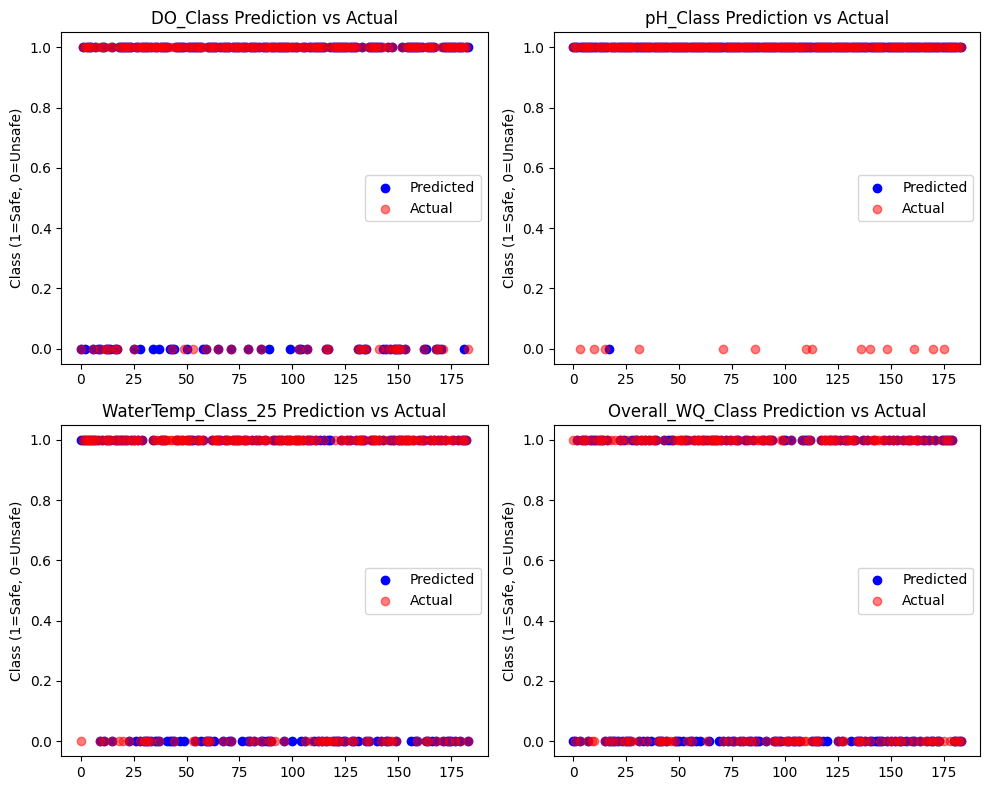

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import smogn
from imblearn.over_sampling import SMOTE, ADASYN
import joblib

# Enable inline plotting in Colab
%matplotlib inline

# Setting random seed for reproducibility
np.random.seed(42)

# 1. Data Collection and Preprocessing
df = pd.read_csv('waterquality.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df = df.groupby('Date').mean().reset_index()

# Create lag features and handle NaN
for target in ['DissolvedOxygen (mg/L)', 'pH', 'WaterTemp (C)']:
    df[f'{target}_lag1'] = df[target].shift(1)
    df[f'{target}_lag1'] = df[f'{target}_lag1'].fillna(df[target].median())

df = df.drop(columns=['Date'])
df = df[df['WaterDepth (m)'] >= 0]
df = df[df['WaterTemp (C)'] >= 0]
df = df[df['AirTemp (C)'] >= -50]

# Drop rows with any remaining NaN before SMOGN
df = df.dropna()

# Verify and fill any remaining missing values
for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:
        df[column] = df[column].fillna(df[column].median())

# Reset index to avoid misalignment
df = df.reset_index(drop=True)

# Features
features = ['Salinity (ppt)', 'AirTemp (C)', 'Year', 'Month', 'SecchiDepth (m)', 'WaterDepth (m)',
            'DissolvedOxygen (mg/L)_lag1', 'pH_lag1', 'WaterTemp (C)_lag1']

# 2. Improve pH predictions with SMOGN (with enhanced parameters)
try:
    df_smogn = smogn.smoter(data=df, y='pH', k=15, samp_method='extreme', rel_thres=0.3)
    print(f"SMOGN generated {len(df_smogn)} synthetic samples.")
    df_smogn = df_smogn.dropna()  # Remove any NaN rows
    # Log synthetic pH distribution
    print(f"Synthetic pH distribution (unsafe <6.5 or >9.0): {len(df_smogn[(df_smogn['pH'] < 6.5) | (df_smogn['pH'] > 9.0)])}")
    df_smogn = df_smogn.reset_index(drop=True)
except ValueError as e:
    print(f"SMOGN failed with error: {e}. Using original data instead.")
    df_smogn = df.copy()

# Encode targets in df_smogn
le = LabelEncoder()
df_smogn['DO_Class'] = df_smogn['DissolvedOxygen (mg/L)'].apply(lambda x: 'unsafe' if x < 5 else 'safe')
df_smogn['DO_Class_encoded'] = le.fit_transform(df_smogn['DO_Class'])  # 0 = unsafe, 1 = safe
df_smogn['pH_Class'] = df_smogn['pH'].apply(lambda x: 'unsafe' if x < 6.5 or x > 9.0 else 'safe')
df_smogn['pH_Class_encoded'] = le.fit_transform(df_smogn['pH_Class'])  # 0 = unsafe, 1 = safe
df_smogn['WaterTemp_Class_25'] = df_smogn['WaterTemp (C)'].apply(lambda x: 'unsafe' if x > 25 else 'safe')
df_smogn['WaterTemp_Class_25_encoded'] = le.fit_transform(df_smogn['WaterTemp_Class_25'])  # 0 = unsafe, 1 = safe
df_smogn['Overall_WQ_Class'] = df_smogn.apply(
    lambda row: 'unsafe' if row['DO_Class'] == 'unsafe' or row['pH_Class'] == 'unsafe' or row['WaterTemp_Class_25'] == 'unsafe'
    else 'safe', axis=1
)
df_smogn['Overall_WQ_Class_encoded'] = le.fit_transform(df_smogn['Overall_WQ_Class'])  # 0 = unsafe, 1 = safe

# Standardize features with df_smogn
scaler = StandardScaler()
X = df_smogn[features]
X_scaled = scaler.fit_transform(X)

# 3. Train Ensemble Models with Weighted Voting
class_targets = ['DO_Class', 'pH_Class', 'WaterTemp_Class_25', 'Overall_WQ_Class']
encoded_targets = ['DO_Class_encoded', 'pH_Class_encoded', 'WaterTemp_Class_25_encoded', 'Overall_WQ_Class_encoded']
ensemble_models = {}
predictions = {}

for target, encoded_target in zip(class_targets, encoded_targets):
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X_scaled, df_smogn[encoded_target], np.arange(len(df_smogn)), stratify=df_smogn[encoded_target], test_size=0.2, random_state=42
    )
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"Training set class distribution for {target} (encoded): {dict(zip(unique, counts))}")
    min_class_count = min(counts) if len(counts) > 1 else len(y_train)
    k_neighbors = min(5, min_class_count - 1) if min_class_count > 1 else 1

    if min_class_count > 1:
        if target == 'pH_Class':
            target_counts = dict(zip(*np.unique(y_train, return_counts=True)))
            unsafe_count = target_counts.get(0, 0)  # 0 = unsafe
            smote = ADASYN(sampling_strategy={1: target_counts.get(1, 0), 0: max(100, unsafe_count)}, n_neighbors=k_neighbors, random_state=42)
        else:
            smote = SMOTE(k_neighbors=k_neighbors, random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print(f"Training set size after SMOTE/ADASYN for {target}: {len(X_train_resampled)}")
    else:
        print(f"Warning: Only one class present in {target} training set. Skipping SMOTE.")
        X_train_resampled, y_train_resampled = X_train, y_train

    # Initialize ensemble models
    dt = DecisionTreeClassifier(random_state=42)
    svm = SVC(kernel='rbf', probability=True, random_state=42)
    nb = GaussianNB()

    # Train models
    dt.fit(X_train_resampled, y_train_resampled)
    svm.fit(X_train_resampled, y_train_resampled)
    nb.fit(X_train_resampled, y_train_resampled)

    # Store models
    ensemble_models[target] = {'DT': dt, 'SVM': svm, 'NB': nb}

    # Predict with probability-weighted voting
    dt_pred = dt.predict(X_test)
    svm_prob = svm.predict_proba(X_test)[:, 0]  # Probability of 'unsafe' (class 0)
    nb_prob = nb.predict_proba(X_test)[:, 0]    # Probability of 'unsafe' (class 0)

    # Adjusted threshold for pH_Class
    if target == 'pH_Class':
        weighted_vote = 0.33 * dt_pred + 0.33 * (svm_prob > 0.5).astype(int) + 0.34 * (nb_prob > 0.5).astype(int)
        ensemble_pred = np.where(weighted_vote >= 0.5, 0, 1)  # Lower threshold to 0.5
    else:
        weighted_vote = 0.33 * dt_pred + 0.33 * (svm_prob > 0.5).astype(int) + 0.34 * (nb_prob > 0.5).astype(int)
        ensemble_pred = np.where(weighted_vote >= 0.6, 0, 1)  # Default threshold 0.6

    # Convert predictions back to original labels for consistency
    ensemble_pred_labels = le.inverse_transform(ensemble_pred)
    y_test_labels = le.inverse_transform(y_test)

    predictions[target] = (y_test_labels, ensemble_pred_labels)

    # Cross-validation
    cv_scores = cross_val_score(dt, X_scaled, df_smogn[encoded_target], cv=5, scoring='accuracy')
    print(f"\n5-Fold CV Accuracy for {target}: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")
    print(f"Classification Metrics for {target}:")
    print(classification_report(y_test_labels, ensemble_pred_labels, target_names=le.classes_, zero_division=0))

# 5. Decision Rule for Overall Water Quality
print("\nDecision Rule Explanation:")
print("Overall water quality is determined by an ensemble of Decision Tree, SVM, and Naive Bayes classifiers.")
print("Each model contributes to a weighted vote: Decision Tree (0.33), SVM (0.33), Naive Bayes (0.34).")
print("A sample is classified as 'unsafe' if the weighted vote exceeds 0.6 (0.5 for pH_Class), otherwise 'safe'.")
print("Individual parameter thresholds are:")
print("- DissolvedOxygen < 5 mg/L: unsafe")
print("- pH < 6.5 or > 9.0: unsafe")
print("- WaterTemp > 25°C: unsafe")
print("The ensemble output is validated against the rule-based Overall_WQ_Class.")

# 6. Water Quality Index (WQI) with corrected prediction
def calculate_wqi(do, ph, temp):
    do_score = 100 if do >= 5 else (do / 5) * 100
    ph_score = 100 if 6.5 <= ph <= 9.0 else max(0, min((ph - 6.5) / 2.5 * 100, (9.0 - ph) / 2.5 * 100))
    temp_score = 100 if temp <= 25 else max(0, 100 - (temp - 25) * 5)
    return (0.17 * do_score) + (0.11 * ph_score) + (0.10 * temp_score)

# Predicted WQI using ensemble-based thresholded values with adjusted pH
do_pred = np.array([5 if p == 'safe' else 4 for p in predictions['DO_Class'][1]])  # Approximate DO
ph_pred = np.array([7.5 if p == 'safe' else 6.2 if p == 'unsafe' and float(df_smogn['pH'].iloc[i]) < 6.5 else 9.2 for i, p in enumerate(predictions['pH_Class'][1])])  # Adjusted pH
temp_pred = np.array([22 if p == 'safe' else 30 for p in predictions['WaterTemp_Class_25'][1]])  # Approximate Temp
wqi_pred = [calculate_wqi(do, ph, temp) for do, ph, temp in zip(do_pred, ph_pred, temp_pred)]
print(f"\nAverage Predicted WQI on Test Set: {np.mean(wqi_pred):.2f}")

# Actual WQI for validation
wqi_actual = [calculate_wqi(y[0], y[1], y[2]) for y in zip(df_smogn['DissolvedOxygen (mg/L)'].iloc[test_idx],
                                                           df_smogn['pH'].iloc[test_idx],
                                                           df_smogn['WaterTemp (C)'].iloc[test_idx])]
print(f"Average Actual WQI on Test Set: {np.mean(wqi_actual):.2f}")

# 7. Plot Predictions vs Actual (Classification)
plt.figure(figsize=(10, 8))
for i, target in enumerate(class_targets, 1):
    y_test, y_pred = predictions[target]
    plt.subplot(2, 2, i)
    plt.scatter(range(len(y_test)), [1 if p == 'safe' else 0 for p in y_pred], c='blue', label='Predicted')
    plt.scatter(range(len(y_test)), [1 if t == 'safe' else 0 for t in y_test], c='red', label='Actual', alpha=0.5)
    plt.title(f'{target} Prediction vs Actual')
    plt.ylabel('Class (1=Safe, 0=Unsafe)')
    plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('classification_vs_actual.png', dpi=300, bbox_inches='tight')
plt.close()

# 8. Save Models
for target, models in ensemble_models.items():
    for name, model in models.items():
        joblib.dump(model, f'{target}_{name}_model.pkl')